In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

### step 1: Load Data

In [16]:
print("Loading data...")
df = pd.read_csv('cleaned_dataset.csv')

Loading data...


### step 2: Create Combined Features

In [17]:
print("\nCreating new feature groups...")

# First normalize the features for better combination
scaler = StandardScaler()
numerical_features = ['feature_1', 'feature_2', 'feature_3', 'feature_4',
                     'feature_5', 'feature_6', 'feature_7', 'feature_8']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Strong Positive Target Predictors (features 1, 2, 4)
df['positive_predictors_mean'] = (df['feature_1'] + df['feature_2'] + df['feature_4']) / 3
df['positive_predictors_std'] = df[['feature_1', 'feature_2', 'feature_4']].std(axis=1)

# Strong Negative Target Predictor (feature 3)
df['negative_predictor_interaction'] = df['feature_3'] * df['positive_predictors_mean']

# Weak Target Predictors (features 6, 7, 8) - only keep if they show interaction effects
df['weak_predictors_mean'] = (df['feature_6'] + df['feature_7'] + df['feature_8']) / 3

# Category and Region Interactions (focus on stronger relationships)
df['category_predictor_interaction'] = df['category_1'] * df['positive_predictors_mean']



Creating new feature groups...


### Step 3: Create Target-Based Interaction Features

In [18]:
print("\nCreating interaction features...")

# Create polynomial features for strong predictors
df['positive_predictors_squared'] = df['positive_predictors_mean'] ** 2

# Create interaction between strong and weak predictors
df['strong_weak_interaction'] = df['positive_predictors_mean'] * df['weak_predictors_mean']


Creating interaction features...


### step 4: Handle Potential Issues

In [19]:
print("\nHandling data issues...")
# Replace infinities
df = df.replace([np.inf, -np.inf], np.nan)
# Fill missing values in numeric columns only
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())



Handling data issues...


### step 5: Evaluate Feature Importance

In [20]:
new_features = [
    'positive_predictors_mean', 
    'positive_predictors_std',
    'negative_predictor_interaction',
    'weak_predictors_mean',
    'category_predictor_interaction',
    'positive_predictors_squared',
    'strong_weak_interaction'
]
# Calculate correlations with target
correlations = pd.DataFrame({
    'feature': new_features,
    'correlation': [df[feature].corr(df['target']) for feature in new_features]
})
correlations = correlations.sort_values('correlation', ascending=False)


### step 6: Visualizing the new features

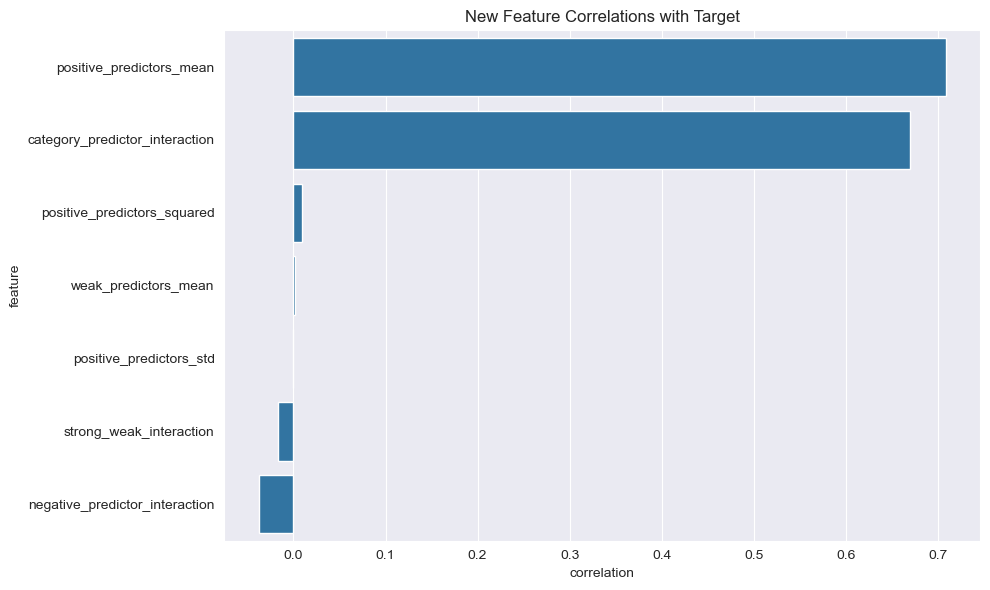

In [21]:
plt.figure(figsize=(10, 6))
sns.barplot(data=correlations, x='correlation', y='feature')
plt.title('New Feature Correlations with Target')
plt.tight_layout()
plt.savefig('new_feature_correlations.png')

### Step 7: Print Feature Justifications


In [22]:
print("\nFeature Justifications:")
justifications = {
    'positive_predictors_mean': 'Average of features 1, 2, 4 which strongly predict target positively',
    'positive_predictors_std': 'Variation in strong positive predictors',
    'negative_predictor_interaction': 'Interaction between negative predictor (feature 3) and positive predictors',
    'weak_predictors_mean': 'Average of features 6, 7, 8 to capture potential subtle patterns',
    'category_predictor_interaction': 'Interaction between category and strong predictors',
    'positive_predictors_squared': 'Non-linear effects of strong predictors',
    'strong_weak_interaction': 'Interaction between strong and weak predictors'
}

for feature, justification in justifications.items():
    print(f"\n{feature}:")
    print(f"- Justification: {justification}")
    print(f"- Correlation with target: {correlations[correlations['feature'] == feature]['correlation'].values[0]:.3f}")



Feature Justifications:

positive_predictors_mean:
- Justification: Average of features 1, 2, 4 which strongly predict target positively
- Correlation with target: 0.709

positive_predictors_std:
- Justification: Variation in strong positive predictors
- Correlation with target: -0.000

negative_predictor_interaction:
- Justification: Interaction between negative predictor (feature 3) and positive predictors
- Correlation with target: -0.038

weak_predictors_mean:
- Justification: Average of features 6, 7, 8 to capture potential subtle patterns
- Correlation with target: 0.002

category_predictor_interaction:
- Justification: Interaction between category and strong predictors
- Correlation with target: 0.670

positive_predictors_squared:
- Justification: Non-linear effects of strong predictors
- Correlation with target: 0.009

strong_weak_interaction:
- Justification: Interaction between strong and weak predictors
- Correlation with target: -0.017


### step 8: Saving the strong correlations

In [23]:
print("\nSelecting features based on strong correlation for best model accuracy")
CORRELATION_THRESHOLD = 0.1

strong_features = correlations[abs(correlations['correlation']) > CORRELATION_THRESHOLD]['feature'].tolist()
print(f"\nFeatures selected based on correlation threshold {CORRELATION_THRESHOLD}:")
for feature in strong_features:
    print(f"- {feature} correlation: {correlations[correlations['feature']==feature]['correlation'].values[0]:.3f}")




Selecting features based on strong correlation for best model accuracy

Features selected based on correlation threshold 0.1:
- positive_predictors_mean correlation: 0.709
- category_predictor_interaction correlation: 0.670


### step 9: Save New Dataset

In [24]:
final_columns = numerical_features + ['category_1'] + \
                [col for col in df.columns if col.startswith('region_')] + \
                strong_features + ['target']

final_df = df[final_columns]
print("\nSaving engineered dataset...")
final_df.to_csv('engineered_dataset.csv', index=False)


Saving engineered dataset...


### step 10: Print Summary Statistics

In [25]:
print("\nSummary:")
print(f"Original features analyzed: {len(numerical_features)}")
print(f"New features created and analyzed: {len(new_features)}")
print(f"New features selected for final dataset: {len(strong_features)}")
print(f"Total features in final dataset: {len(final_columns)}")


Summary:
Original features analyzed: 8
New features created and analyzed: 7
New features selected for final dataset: 2
Total features in final dataset: 15
